In [1]:
# 1. Import Libraries
import pandas as pd                      
import numpy as np                       
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder   
from sklearn.compose import ColumnTransformer                      
from sklearn.pipeline import Pipeline                             
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report)  
from sklearn.feature_selection import RFECV                        
from sklearn.ensemble import RandomForestClassifier               
from sklearn.svm import SVC                                        
from sklearn.neighbors import KNeighborsClassifier               
from xgboost import XGBClassifier                                 
from lightgbm import LGBMClassifier                             
from catboost import CatBoostClassifier                            
from imblearn.over_sampling import SMOTE                           
from imblearn.pipeline import Pipeline as ImbPipeline              
import warnings

In [2]:
# 2. Load Data
df = pd.read_csv('Loan_default.csv')

In [3]:
# 불필요 컬럼 제거
df.drop(columns=['LoanID'], inplace=True)

In [4]:
print(df.isnull().sum())

Age               143
Income              0
LoanAmount          0
CreditScore         0
MonthsEmployed      0
NumCreditLines      0
InterestRate        0
LoanTerm            0
DTIRatio            0
Education           0
EmploymentType      0
MaritalStatus       0
HasMortgage         0
HasDependents       0
LoanPurpose         0
HasCoSigner         0
Default             0
dtype: int64


In [5]:
df = df.dropna(subset=['Age'])

In [6]:
import pandas as pd
import numpy as np

# 수치형, 범주형 컬럼 분리 (타깃 컬럼 제외)
target_col = 'Default'
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

results = []

# 1. 수치형 변수: 피어슨 상관계수 (절대값)
for col in numeric_cols:
    corr = df[[col, target_col]].corr().iloc[0,1]
    results.append({
        'Variable': col,
        'Type': 'Numeric',
        'RelationStrength': abs(corr)
    })

# 2. 범주형 변수: Default 평균값 차이 (최대-최소, 절대값)
for col in categorical_cols:
    group_mean = df.groupby(col)[target_col].mean()
    diff = abs(group_mean.max() - group_mean.min())
    results.append({
        'Variable': col,
        'Type': 'Categorical',
        'RelationStrength': diff
    })

# 통합 결과 DataFrame으로 정리, RelationStrength 기준 내림차순 정렬
relation_df = pd.DataFrame(results).sort_values(by='RelationStrength', ascending=False).reset_index(drop=True)

print(relation_df)

          Variable         Type  RelationStrength
0              Age      Numeric          0.164731
1     InterestRate      Numeric          0.138749
2           Income      Numeric          0.097123
3   MonthsEmployed      Numeric          0.093264
4       LoanAmount      Numeric          0.085787
5   EmploymentType  Categorical          0.040812
6      CreditScore      Numeric          0.036276
7   NumCreditLines      Numeric          0.034224
8      LoanPurpose  Categorical          0.022608
9      HasCoSigner  Categorical          0.022421
10       Education  Categorical          0.021754
11   MaritalStatus  Categorical          0.020825
12        DTIRatio      Numeric          0.020250
13   HasDependents  Categorical          0.020082
14        LoanTerm      Numeric          0.012689
15     HasMortgage  Categorical          0.011627


In [7]:
from sklearn.feature_selection import mutual_info_classif

# 수치형, 범주형 피처 분리
target_col = 'Default'
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(target_col)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
feature_cols = list(numeric_cols) + list(categorical_cols)

# X, y 정의
X = df[feature_cols]
y = df[target_col]

# 범주형 변수 인코딩 (수치형은 그대로, 범주형만 OrdinalEncoder)
from sklearn.preprocessing import OrdinalEncoder

X_encoded = X.copy()
if len(categorical_cols) > 0:
    X_encoded[categorical_cols] = OrdinalEncoder().fit_transform(X[categorical_cols])

# MI 계산
mi = mutual_info_classif(X_encoded, y, discrete_features=[col in categorical_cols for col in feature_cols], random_state=42)

# 결과 정리
mi_df = pd.DataFrame({'Variable': feature_cols, 'MutualInformation': mi})
mi_df = mi_df.sort_values(by='MutualInformation', ascending=False).reset_index(drop=True)

print(mi_df)

          Variable  MutualInformation
0              Age           0.011134
1     InterestRate           0.010867
2   MonthsEmployed           0.007881
3   NumCreditLines           0.002995
4           Income           0.002683
5       LoanAmount           0.001553
6   EmploymentType           0.001069
7      CreditScore           0.001009
8      HasCoSigner           0.000613
9    HasDependents           0.000491
10   MaritalStatus           0.000406
11     LoanPurpose           0.000326
12       Education           0.000295
13     HasMortgage           0.000165
14        DTIRatio           0.000061
15        LoanTerm           0.000000


In [8]:
df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,64.0,31676,210929,412,106,1,18.75,36,0.72,Bachelor's,Self-employed,Married,Yes,No,Education,No,0
1,50.0,65524,194613,824,56,2,21.85,24,0.73,Master's,Part-time,Divorced,Yes,No,Home,Yes,1
2,35.0,113815,242949,567,108,3,5.24,36,0.84,Bachelor's,Part-time,Married,No,Yes,Education,Yes,0
3,49.0,124980,233469,522,68,2,13.16,48,0.60,Bachelor's,Unemployed,Divorced,No,No,Home,Yes,0
4,50.0,20469,41414,698,33,3,14.54,12,0.51,Bachelor's,Unemployed,Divorced,Yes,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,43.0,78498,202886,600,46,3,9.23,36,0.33,Bachelor's,Unemployed,Divorced,Yes,Yes,Business,Yes,0
24996,19.0,95118,111037,331,3,1,17.74,12,0.60,Bachelor's,Full-time,Married,No,No,Auto,No,0
24997,46.0,40878,88307,458,61,2,11.16,48,0.13,Bachelor's,Self-employed,Single,Yes,No,Home,No,0
24998,59.0,147472,18893,809,46,1,2.99,60,0.77,PhD,Part-time,Married,Yes,No,Other,No,0


In [9]:
binary_map = {'Yes': 1, 'No': 0}
for col in ['HasMortgage', 'HasDependents', 'HasCoSigner']:
    df[col] = df[col].map(binary_map)

In [10]:
education_order = ['High School', "Bachelor's", "Master's", "PhD"]
od = OrdinalEncoder(categories=[education_order])
df['Education'] = od.fit_transform(df[['Education']]).astype(int)

In [11]:
# 원 -핫 인코딩
df = pd.get_dummies(df, columns=['EmploymentType', 'MaritalStatus', 'LoanPurpose'], drop_first=True)

In [12]:
# Split Data
X = df.drop('Default', axis=1)
y = df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [38]:
#  SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [13]:
df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,...,Default,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,64.0,31676,210929,412,106,1,18.75,36,0.72,1,...,0,False,True,False,True,False,False,True,False,False
1,50.0,65524,194613,824,56,2,21.85,24,0.73,2,...,1,True,False,False,False,False,False,False,True,False
2,35.0,113815,242949,567,108,3,5.24,36,0.84,1,...,0,True,False,False,True,False,False,True,False,False
3,49.0,124980,233469,522,68,2,13.16,48,0.60,1,...,0,False,False,True,False,False,False,False,True,False
4,50.0,20469,41414,698,33,3,14.54,12,0.51,1,...,0,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,43.0,78498,202886,600,46,3,9.23,36,0.33,1,...,0,False,False,True,False,False,True,False,False,False
24996,19.0,95118,111037,331,3,1,17.74,12,0.60,1,...,0,False,False,False,True,False,False,False,False,False
24997,46.0,40878,88307,458,61,2,11.16,48,0.13,1,...,0,False,True,False,False,True,False,False,True,False
24998,59.0,147472,18893,809,46,1,2.99,60,0.77,3,...,0,True,False,False,True,False,False,False,False,True


In [14]:
# Standard Scaling (수치형 변수)
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if col not in ['Default', 'Education']]

In [15]:
scaler = ColumnTransformer([
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')

In [16]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
feature_names = num_cols + [col for col in X.columns if col not in num_cols]
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [17]:
X_train_scaled = X_train_scaled.astype(float)
X_test_scaled = X_test_scaled.astype(float)

In [18]:
# object 타입(문자열) 컬럼 확인
print(X_train_scaled.select_dtypes(include='object').columns)

Index([], dtype='object')


# Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# 1. 모델 생성 및 학습
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# 2. 예측
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

# 3. 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8584070796460177
Precision: 0.28027681660899656
Recall: 0.14038128249566725
F1 Score: 0.18706697459584296
ROC AUC: 0.6853739182898481

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      4395
           1       0.28      0.14      0.19       577

    accuracy                           0.86      4972
   macro avg       0.59      0.55      0.55      4972
weighted avg       0.82      0.86      0.84      4972



# XGBoost

In [46]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)
y_proba = xgb.predict_proba(X_test_scaled)[:, 1]

print("[XGBoost]")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

[XGBoost]
Accuracy: 0.8757039420756235
Precision: 0.3969849246231156
Recall: 0.1369150779896014
F1 Score: 0.2036082474226804
ROC AUC: 0.700426078949807
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4395
           1       0.40      0.14      0.20       577

    accuracy                           0.88      4972
   macro avg       0.65      0.55      0.57      4972
weighted avg       0.84      0.88      0.85      4972



# LightGBM

In [35]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train_scaled, y_train)
y_pred = lgb.predict(X_test_scaled)
y_proba = lgb.predict_proba(X_test_scaled)[:, 1]

print("[LightGBM]")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 17576, number of negative: 17576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 35152, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM]
Accuracy: 0.8795253419147224
Precision: 0.43209876543209874
Recall: 0.12131715771230503
F1 Score: 0.18944519621109607
ROC AUC: 0.7191447662875137
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4395
           1       0.43      0.12      0.19       577

    accuracy                           0.88      4972
   macro avg       0.66      0.55      0.56      4972
weighted avg       0.84      0.88      0.85      4972



# CatBoost

In [47]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train_scaled, y_train)
y_pred = cat.predict(X_test_scaled)
y_proba = cat.predict_proba(X_test_scaled)[:, 1]

print("[CatBoost]")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

[CatBoost]
Accuracy: 0.8775140788415124
Precision: 0.4148936170212766
Recall: 0.13518197573656845
F1 Score: 0.20392156862745098
ROC AUC: 0.7071427867258958
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4395
           1       0.41      0.14      0.20       577

    accuracy                           0.88      4972
   macro avg       0.66      0.56      0.57      4972
weighted avg       0.84      0.88      0.85      4972



# KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
# KNN은 predict_proba 지원
y_proba = knn.predict_proba(X_test_scaled)[:, 1]

print("[KNN]")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

[KNN]
Accuracy: 0.7355189058728882
Precision: 0.18887015177065766
Recall: 0.3882149046793761
F1 Score: 0.2541123085649461
ROC AUC: 0.6307654239199658
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      4395
           1       0.19      0.39      0.25       577

    accuracy                           0.74      4972
   macro avg       0.55      0.58      0.55      4972
weighted avg       0.82      0.74      0.77      4972



# SVM

In [49]:
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=42)
svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)
y_proba = svc.predict_proba(X_test_scaled)[:, 1]

print("[SVM]")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

[SVM]
Accuracy: 0.8425181013676589
Precision: 0.2626728110599078
Recall: 0.1975736568457539
F1 Score: 0.22551928783382788
ROC AUC: 0.651356216592433
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      4395
           1       0.26      0.20      0.23       577

    accuracy                           0.84      4972
   macro avg       0.58      0.56      0.57      4972
weighted avg       0.82      0.84      0.83      4972



In [52]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 모델 리스트 및 이름
models = [
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(probability=True, random_state=42))
]

results = []

for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # 각 클래스별 지표 (array 반환: [class 0, class 1])
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision_0': precision[0],
        'Precision_1': precision[1],
        'Recall_0': recall[0],
        'Recall_1': recall[1],
        'F1_0': f1[0],
        'F1_1': f1[1],
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    })

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

[LightGBM] [Info] Number of positive: 17576, number of negative: 17576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 35152, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
          Model  Accuracy  Precision_0  Precision_1  Recall_0  Recall_1  \
0  RandomForest  0.858407     0.894085     0.280277  0.952673  0.140381   
1       XGBoost  0.875704     0.895663     0.396985  0.972696  0.136915   
2      LightGBM  0.879525     0.894595     0.432099  0.979067  0.121317   
3      CatBoost  0.877514     0.895694     0.414894  0.974972  0.135182   
4           KNN  0.735519     0.906762     0.188870  0.781115  0.388215   
5           SVM  0.842518     0.897973     0.26

# class_weight 적용 LightGBM

In [19]:
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    fbeta_score
)

# 1. LightGBM 모델 정의 및 학습 (class_weight 적용)
lgbm_clf = LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
lgbm_clf.fit(X_train_scaled, y_train)

# 2. 예측
y_pred = lgbm_clf.predict(X_test_scaled)
y_proba = lgbm_clf.predict_proba(X_test_scaled)[:, 1]

# 3. 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("F2-score:", fbeta_score(y_test, y_pred, beta=2))   # F2-score 추가
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 2309, number of negative: 17576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 19885, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Accuracy: 0.7413515687851971
Precision: 0.23876197494473103
Recall: 0.561525129982669
F1-score: 0.33505687693898656
F2-score: 0.44201909959072305
ROC-AUC: 0.7327027916945166

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84      4395
           1       0.24      0.56      0.34       577

    accuracy                           0.74      4972
   macro avg       0.58   

# 하이퍼파라미터 튜닝 (GridsearchCV)

In [20]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# 하이퍼파라미터 후보 지정
param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# 클래스 가중치 적용 모델 정의
lgbm = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='f1',         # 혹은 'roc_auc', 'recall' 등 목적에 맞게
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습 (fit)
grid_search.fit(X_train_scaled, y_train)

# 최적 하이퍼파라미터 및 점수 확인
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# 테스트셋 평가
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test_scaled)
y_proba = best_lgbm.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test F1-score:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 2309, number of negative: 17576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 19885, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
Best F1 Score: 0.3325824159613613
Test Accuracy: 0.7393403057119872
Test Precision: 0.24376336421952957
Test Recall: 0.5927209705372617
Test F1-score: 0.34545454545454546
Test ROC-AUC: 0.7372703738098477

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84   

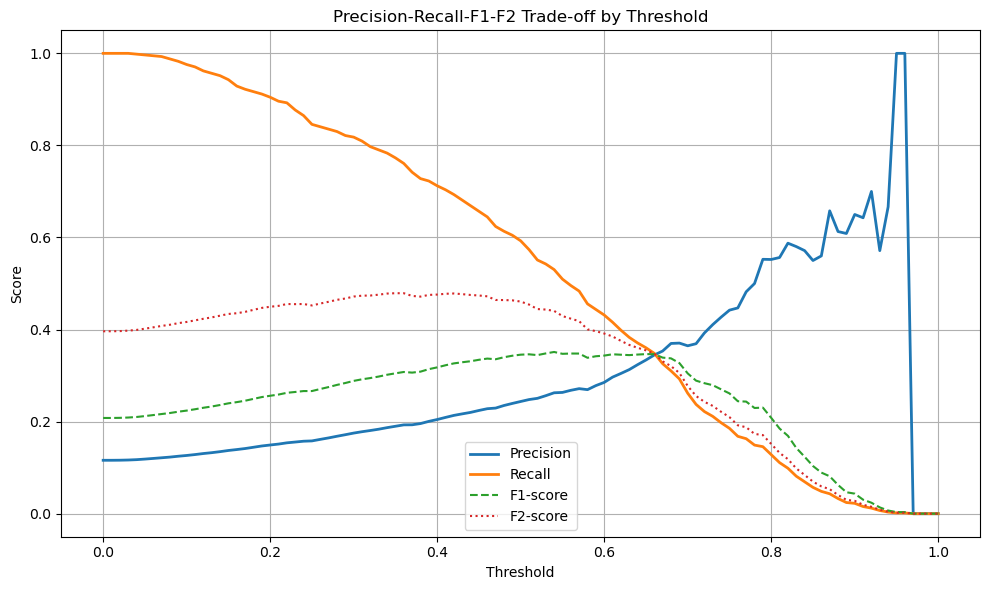

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

# best_lgbm은 이미 그리드서치로 찾은 최적 모델이라고 가정
y_proba = best_lgbm.predict_proba(X_test_scaled)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precision_list = []
recall_list = []
f1_list = []
f2_list = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precision_list.append(precision_score(y_test, y_pred, zero_division=0))
    recall_list.append(recall_score(y_test, y_pred, zero_division=0))
    f1_list.append(f1_score(y_test, y_pred, zero_division=0))
    f2_list.append(fbeta_score(y_test, y_pred, beta=2, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision', linewidth=2)
plt.plot(thresholds, recall_list, label='Recall', linewidth=2)
plt.plot(thresholds, f1_list, label='F1-score', linestyle='--')
plt.plot(thresholds, f2_list, label='F2-score', linestyle=':')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1-F2 Trade-off by Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
import numpy as np
from sklearn.metrics import f1_score, fbeta_score


y_proba = best_lgbm.predict_proba(X_test_scaled)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
f2_scores = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
    f2_scores.append(fbeta_score(y_test, y_pred, beta=2, zero_division=0))

# F1-score 최대 임계값
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

# F2-score 최대 임계값
best_f2_idx = np.argmax(f2_scores)
best_f2_threshold = thresholds[best_f2_idx]
best_f2 = f2_scores[best_f2_idx]

print(f"F1-score 최대 임계값: {best_f1_threshold:.2f}, F1-score: {best_f1:.4f}")
print(f"F2-score 최대 임계값: {best_f2_threshold:.2f}, F2-score: {best_f2:.4f}")

# (선택) 해당 임계값에서의 Precision, Recall 등도 같이 확인
from sklearn.metrics import precision_score, recall_score

for name, t in [('F1-score', best_f1_threshold), ('F2-score', best_f2_threshold)]:
    y_pred = (y_proba >= t).astype(int)
    p = precision_score(y_test, y_pred, zero_division=0)
    r = recall_score(y_test, y_pred, zero_division=0)
    print(f"{name} 최적 임계값 {t:.2f}: Precision={p:.4f}, Recall={r:.4f}")

F1-score 최대 임계값: 0.54, F1-score: 0.3513
F2-score 최대 임계값: 0.35, F2-score: 0.4790
F1-score 최적 임계값 0.54: Precision=0.2627, Recall=0.5303
F2-score 최적 임계값 0.35: Precision=0.1899, Recall=0.7730


ROC AUC: 0.7373


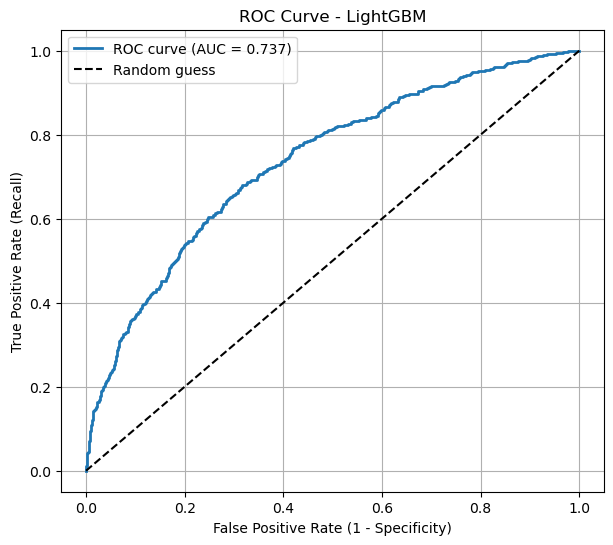

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. 예측 확률값 얻기 (양성 클래스 1의 확률)
y_proba = best_lgbm.predict_proba(X_test_scaled)[:, 1]

# 2. ROC 커브 좌표 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 3. AUC 점수 계산
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc_score:.4f}")

# 4. ROC 커브 시각화
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - LightGBM')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# 1. 예측 확률 구하기
y_proba = best_lgbm.predict_proba(X_test_scaled)[:, 1]

# 2. threshold 0.35로 예측값 변환
threshold = 0.35
y_pred_thresh = (y_proba >= threshold).astype(int)

# 3. 성능 평가
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report

precision = precision_score(y_test, y_pred_thresh)
recall = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)
f2 = fbeta_score(y_test, y_pred_thresh, beta=2)
roc_auc = roc_auc_score(y_test, y_proba)  # ROC-AUC는 threshold 무관 확률 기반

print(f"Threshold: {threshold}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"F2-score: {f2:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_thresh))

Threshold: 0.35
Precision: 0.1899
Recall: 0.7730
F1-score: 0.3050
F2-score: 0.4790
ROC-AUC: 0.7373

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.57      0.71      4395
           1       0.19      0.77      0.30       577

    accuracy                           0.59      4972
   macro avg       0.57      0.67      0.51      4972
weighted avg       0.86      0.59      0.66      4972



# LighgGBM Feature Importance

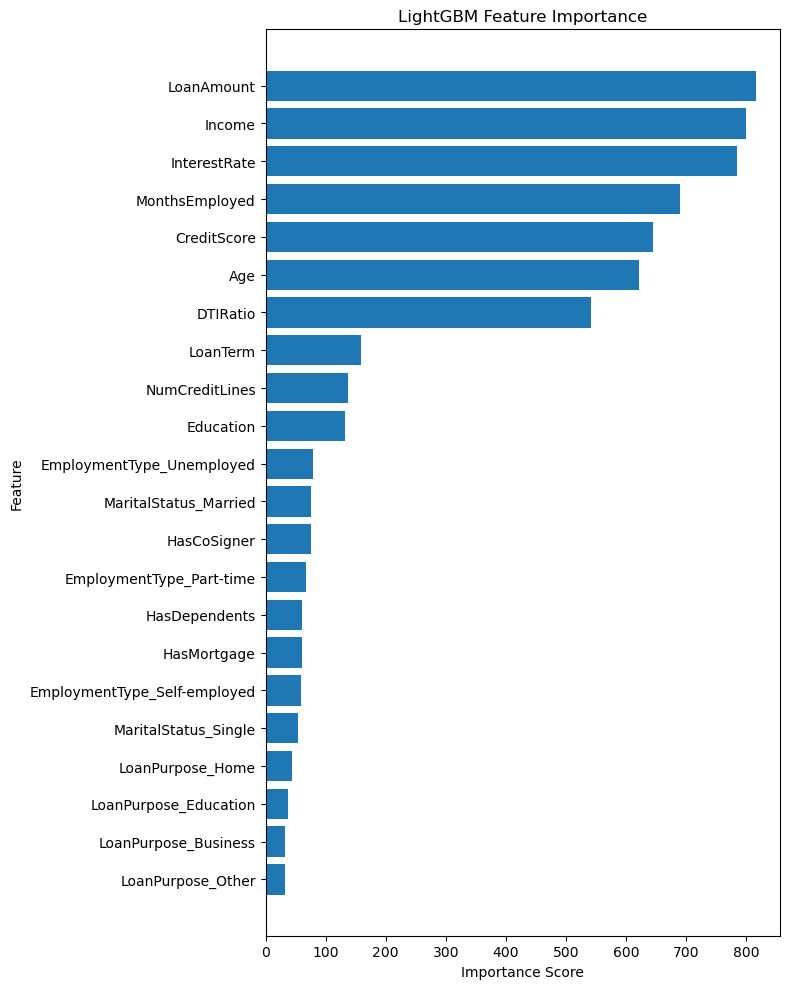

In [30]:
import matplotlib.pyplot as plt

importances = best_lgbm.feature_importances_
feature_names = X_train_scaled.columns

indices = importances.argsort()[::-1]

plt.figure(figsize=(8, 10))  # 세로형이므로 height를 더 키움
plt.title("LightGBM Feature Importance")
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # 가장 중요한 feature가 위로 오도록
plt.tight_layout()
plt.show()


# SHAP value

In [31]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


C:\Users\User\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<class 'numpy.ndarray'> (4972, 22)


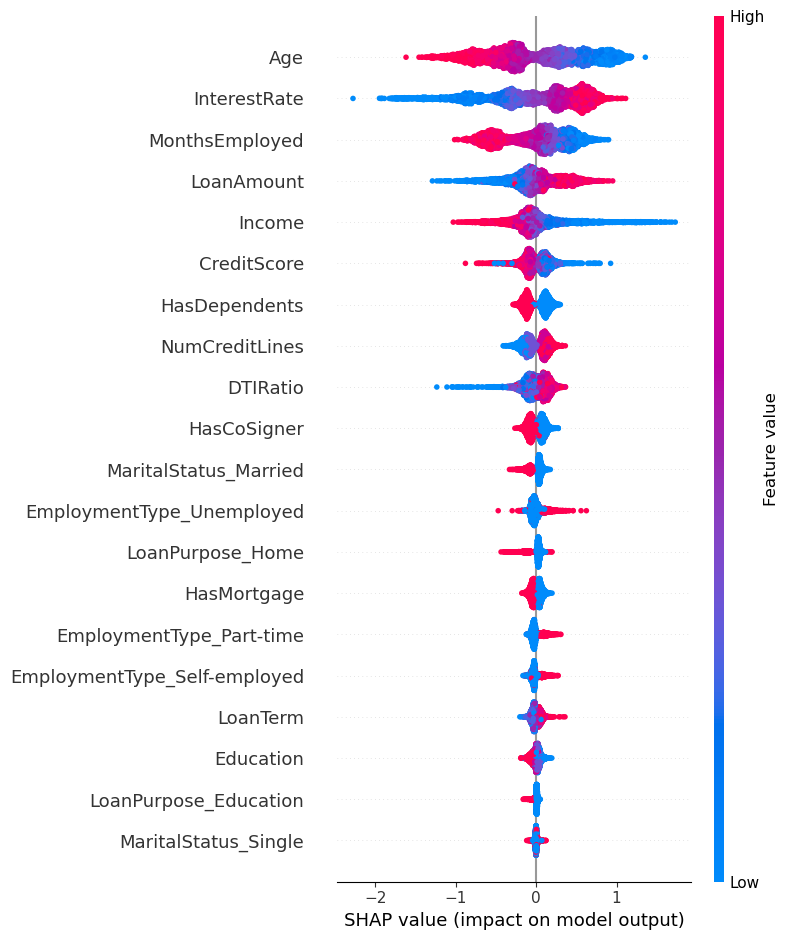

In [34]:
import shap

explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test_scaled)

# shape 확인(디버깅용)
print(type(shap_values), [sv.shape for sv in shap_values] if isinstance(shap_values, list) else shap_values.shape)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test_scaled.columns)